# Bike Sharing

The goal for this week’s project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather,

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

### Checking the data

We want the date as datetime instead of object, to make it easier to extract the time, month and year

In [2]:
df = pd.read_csv('train.csv',parse_dates=['datetime'])   
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
#df = df.rename(columns={'count': 'total_bikes'})

In [4]:
df.shape

(10886, 12)

In [5]:
df.dtypes  

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [6]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Checking NaN values

In [7]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<b>Luckily we do not have to deal with null values

### Extract year, month, day and hour from the datetime column

In [8]:
df['year'] = df['datetime'].dt.year                   #now I have 4 more columns
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour                   #do we new a rush hour column?
df.dtypes    

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
hour                   int64
dtype: object

<b> ------------------

### Exploring output variable (count)

In [9]:
df["count"].mean()

191.57413191254824

/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:>

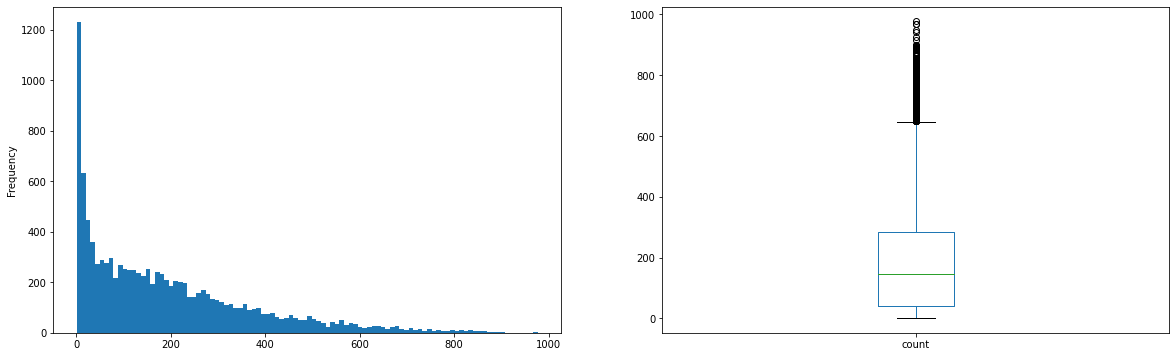

In [10]:
fig,ax = plt.subplots(1, 2)
fig.set_size_inches(20,6)
df['count'].plot(kind = 'hist', bins=100, ax =ax[0])
df['count'].plot(kind = 'box', ax =ax[1])

### Exploring input variables

<b>- Month and Year

<AxesSubplot:title={'center':'Average number of bikes per hour per year'}, xlabel='year'>

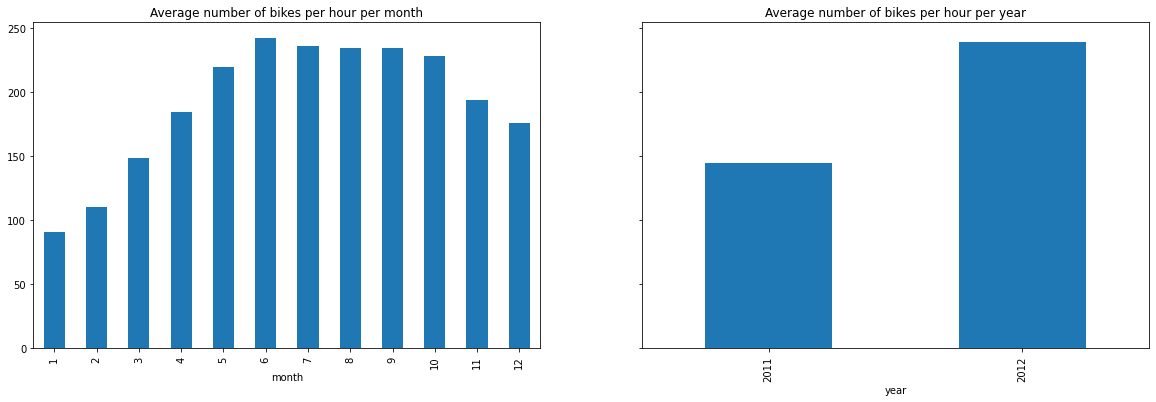

In [11]:
fig, ax = plt.subplots(1, 2,sharey=True)
fig.set_size_inches(20,6)
df.groupby('month')['count'].mean().plot.bar(title="Average number of bikes per hour per month",ax = ax[0])
df.groupby('year')['count'].mean().plot.bar(title="Average number of bikes per hour per year",ax = ax[1])
#plt.savefig('working_date.jpg', dpi=200)

- We can see that the maximum is between May and October, without much variation in these months. The minimum is in January and February, the coldest months of winter

- In addition, in 2012 many more bikes were rented, possibly because the service was already more famous. Therefore, let's see how was the distribution by months in each of the years.

In [12]:
year_2011 = df[df["year"] == 2011]
year_2012 = df[df["year"] == 2012]

/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Text(0.5, 1.0, 'Average number of bikes per hour - 2012')

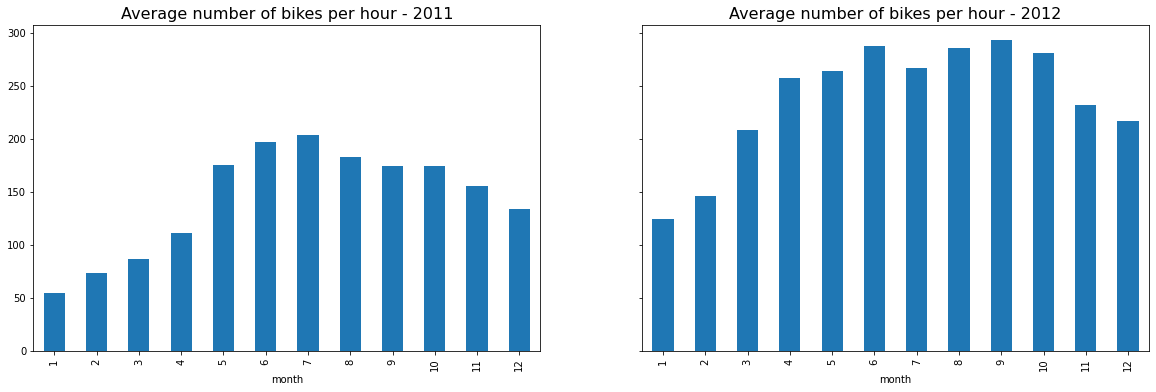

In [13]:
fig, ax = plt.subplots(1, 2,sharey=True)
fig.set_size_inches(20,6)
year_2011.groupby('month')['count'].mean().plot.bar(ax = ax[0])
ax[0].set_title("Average number of bikes per hour - 2011",fontsize=16)
plt.title("Straight Line Function Chart", fontsize=10)
year_2012.groupby('month')['count'].mean().plot.bar(ax = ax[1])
ax[1].set_title("Average number of bikes per hour - 2012",fontsize=16)

In [14]:
#year_2011['month_bin'] = year_2011['month'].replace([1,2,3],'low')
#year_2011['month_bin'] = year_2011['month_bin'].replace([4,5,6,7,8,9,10,11,12],'medium')

#year_2012['month_bin'] = year_2012['month'].replace([1,2,3,12],'medium')
#year_2012['month_bin'] = year_2012['month_bin'].replace([4,5,6,7,8,9,10,11],'high')


- The pattern repeats itself, but with higher figures. It changes quite a bit from 2011 to 2012.

<b>- Temperature and "Feel likes temperature"

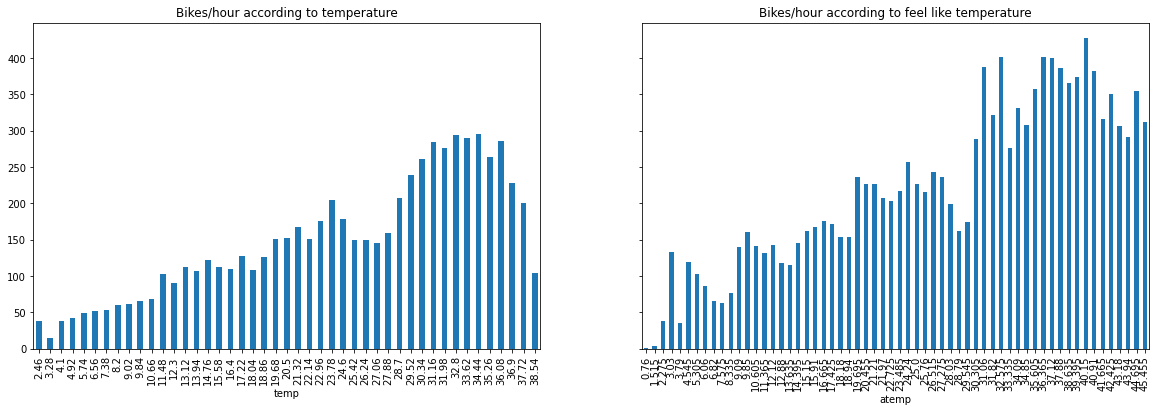

In [15]:
fig, ax = plt.subplots(1, 2,sharey=True)
fig.set_size_inches(20,6)
year_2011.groupby('temp')['count'].mean().plot.bar(title="Bikes/hour according to temperature",ax = ax[0])
year_2012.groupby('atemp')['count'].mean().plot.bar(title="Bikes/hour according to feel like temperature", ax = ax[1])
plt.savefig('temp_atemp.jpg', dpi=200)

- The number of bicycles increases when both types of temperature rise, which are highly correlated.

<b>- Humidity

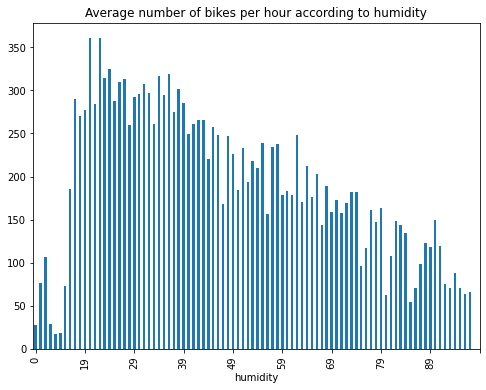

In [16]:
df.groupby('humidity')['count'].mean().plot.bar(title="Average number of bikes per hour according to humidity", figsize=(8,6))
plt.savefig('humidty.jpg', dpi=200)
plt.xticks(range(0, 100, 10))
plt.show()

- Contrary to temperature, the amount of bicycles decreases with increasing temperature. Exception for values lower than 10% humidity. Possible outliers.

<b>- Weather

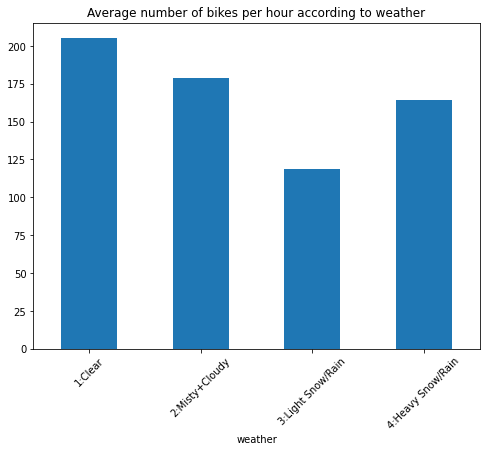

In [17]:
#fig, ax = plt.subplots(1, 1)
#fig.set_size_inches(20,10)
df.groupby('weather')['count'].mean().plot.bar(figsize=(8,6))
plt.title("Average number of bikes per hour according to weather")
plt.xticks([0 ,1, 2, 3], ['1:Clear','2:Misty+Cloudy', '3:Light Snow/Rain', '4:Heavy Snow/Rain' ])
plt.xticks(rotation = 45) 
plt.figsize=(8,6)
plt.savefig('weather.jpg', dpi=200)

In [18]:
df.groupby('weather')['count'].mean()

weather
1    205.236791
2    178.955540
3    118.846333
4    164.000000
Name: count, dtype: float64

In [19]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

<b> It's weird the mean is higher when there is heavy snow/rain than light snow/rain! 

- If we look up how many entries we have with that weather, we realize that there is only one. For that reason, we cannot generalize and draw the conclusion that people rent more bikes with heavy snow/rain than with light snow/rain!
- Solution: replace the value of 4 in 3, it is not worth having this category with only one entry and that also looks like an outlier.

In [20]:
df['weather'] = df['weather'].replace([4],3)
df['weather'].value_counts()

1    7192
2    2834
3     860
Name: weather, dtype: int64

#### - Working day

In [21]:
df.groupby('workingday')['count'].mean()

workingday
0    188.506621
1    193.011873
Name: count, dtype: float64

In [22]:
df["workingday"]

0        0
1        0
2        0
3        0
4        0
        ..
10881    1
10882    1
10883    1
10884    1
10885    1
Name: workingday, Length: 10886, dtype: int64

In [23]:
working_date = df[df["workingday"] == 1]
working_date.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
47,2011-01-03 00:00:00,1,0,1,1,9.02,9.850,44,23.9994,0,5,5,2011,1,3,0
48,2011-01-03 01:00:00,1,0,1,1,8.20,8.335,44,27.9993,0,2,2,2011,1,3,1
49,2011-01-03 04:00:00,1,0,1,1,6.56,6.820,47,26.0027,0,1,1,2011,1,3,4
50,2011-01-03 05:00:00,1,0,1,1,6.56,6.820,47,19.0012,0,3,3,2011,1,3,5
51,2011-01-03 06:00:00,1,0,1,1,5.74,5.305,50,26.0027,0,30,30,2011,1,3,6


In [24]:
not_working_date = df[df["workingday"] == 0]
not_working_date.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


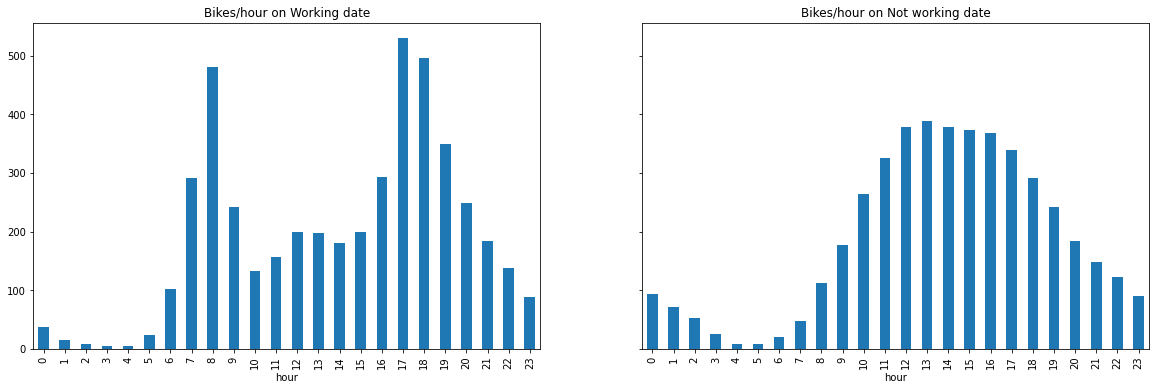

In [25]:
fig, ax = plt.subplots(1, 2,sharey=True)
fig.set_size_inches(20,6)
working_date.groupby('hour')['count'].mean().plot.bar(title="Bikes/hour on Working date",ax = ax[0])
not_working_date.groupby('hour')['count'].mean().plot.bar(title="Bikes/hour on Not working date",ax = ax[1])
plt.savefig('working_date.jpg', dpi=200)

<b> The average is slightly higher on not-working days than on working days, but the time distribution is very different

- During night time (from 20h to 6h), we have similar numbers on both type of days.

- On working 
days the fluctuation is greater, with two major peaks between 7am and 9am (work start time) and 5pm and 7pm (work end time).

- On not working days, the count starts to increase at 8:00 am, reaching its maximum between 12:00 and 4:00 pm and then slowly decreases again.in.

In [26]:
print("There are " + str(len(df)) + " observations")

There are 10886 observations


In [27]:
print("There are " + str(len(df[df["workingday"] == 1])) + " working day observations")

There are 7412 working day observations


In [28]:
print("There are " + str(len(df[df["holiday"] == 1])) + " holiday day observations")

There are 311 holiday day observations


<b>Working day + holiday != all the observations. Ther are a "hidden" feature, the weekends!

<b>- Holidays

In [29]:
df.groupby('holiday')['count'].mean()

holiday
0    191.741655
1    185.877814
Name: count, dtype: float64

<AxesSubplot:title={'center':'Average number of bikes per hour according to holiday'}, xlabel='holiday'>

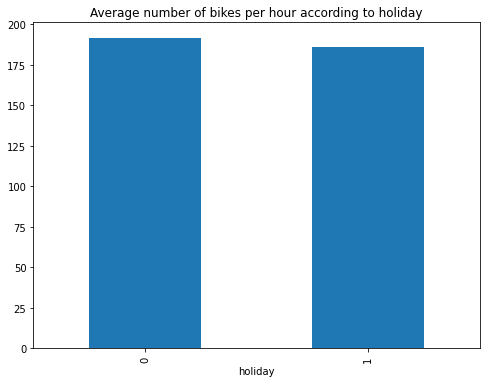

In [30]:
df.groupby('holiday')['count'].mean().plot.bar(title="Average number of bikes per hour according to holiday", figsize=(8,6))
#plt.savefig('humidty.jpg', dpi=200)

/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


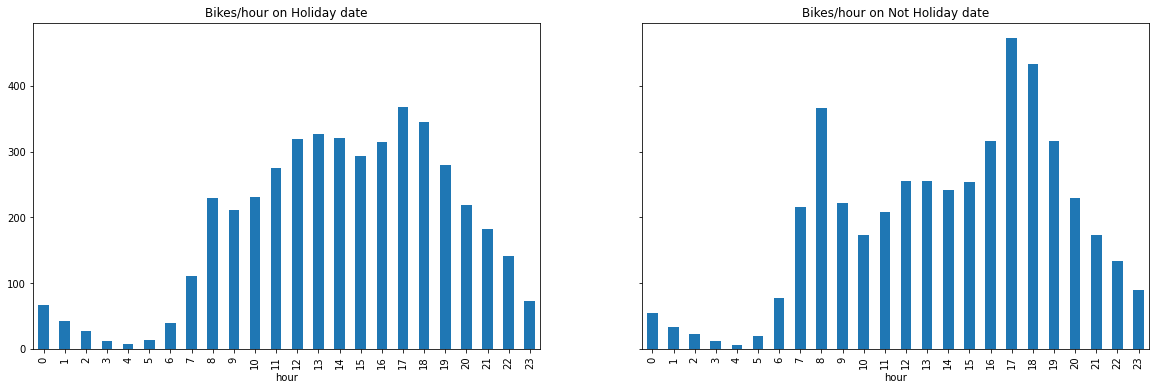

In [31]:
holiday_date = df[df["holiday"] == 1]
not_holiday_date = df[df["holiday"] == 0]
fig, ax = plt.subplots(1, 2,sharey=True)
fig.set_size_inches(20,6)
holiday_date.groupby('hour')['count'].mean().plot.bar(title="Bikes/hour on Holiday date",ax = ax[0])
not_holiday_date.groupby('hour')['count'].mean().plot.bar(title="Bikes/hour on Not Holiday date",ax = ax[1])
plt.savefig('holiday.jpg', dpi=200)

In [32]:
weekends = not_working_date[not_working_date['holiday'] == 0]

In [33]:
not_working_date.holiday.value_counts()

0    3163
1     311
Name: holiday, dtype: int64

In [34]:
weekends["count"].mean()

188.7650964274423

<AxesSubplot:xlabel='hour'>

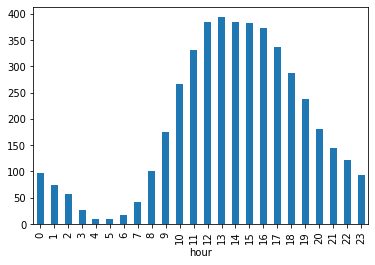

In [35]:
weekends.groupby('hour')['count'].mean().plot.bar()

/home/dani/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


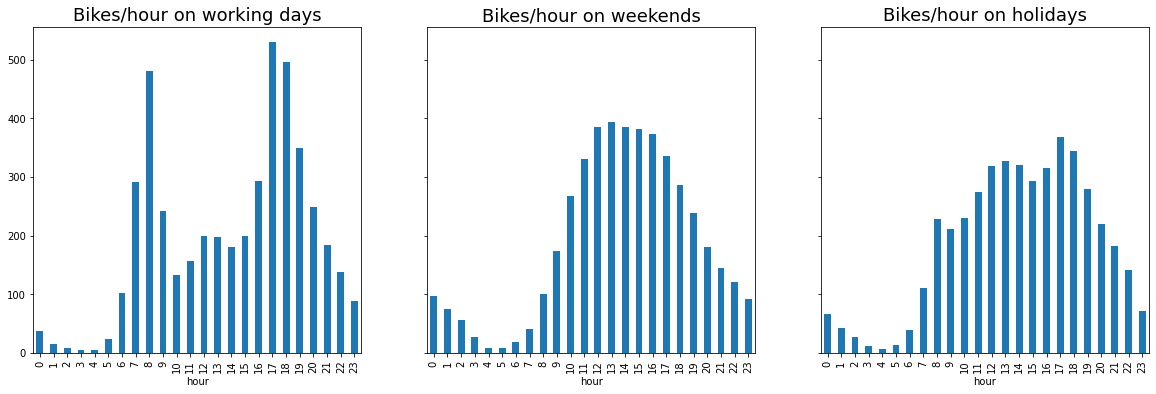

In [36]:
holiday_date = df[df["holiday"] == 1]
fig, ax = plt.subplots(1, 3,sharey=True)
fig.set_size_inches(20,6)
working_date.groupby('hour')['count'].mean().plot.bar(ax = ax[0])
weekends.groupby('hour')['count'].mean().plot.bar(ax = ax[1])
holiday_date.groupby('hour')['count'].mean().plot.bar(ax = ax[2])
ax[0].set_title("Bikes/hour on working days",fontsize=18)
ax[1].set_title("Bikes/hour on weekends",fontsize=18)
ax[2].set_title("Bikes/hour on holidays",fontsize=18)
plt.savefig('holiday-working.jpg', dpi=200)


In [37]:
df.groupby('holiday')['count'].mean()

holiday
0    191.741655
1    185.877814
Name: count, dtype: float64

<b>- Windpeed

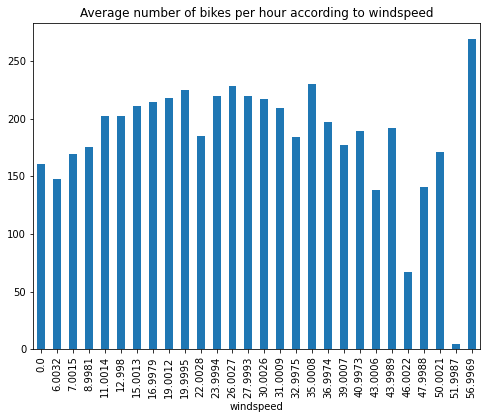

In [38]:
df.groupby('windspeed')['count'].mean().plot.bar(title="Average number of bikes per hour according to windspeed", figsize=(8,6))
plt.savefig('windspeed.jpg', dpi=200)

In [39]:
df['windspeed'].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
50.0021       1
51.9987       1
Name: windspeed, dtype: int64

- 2 observations: there are a lot of 0 values, and also a strangely high value of bikes with a windspeed of 56.9969!

------ 

### Histogram

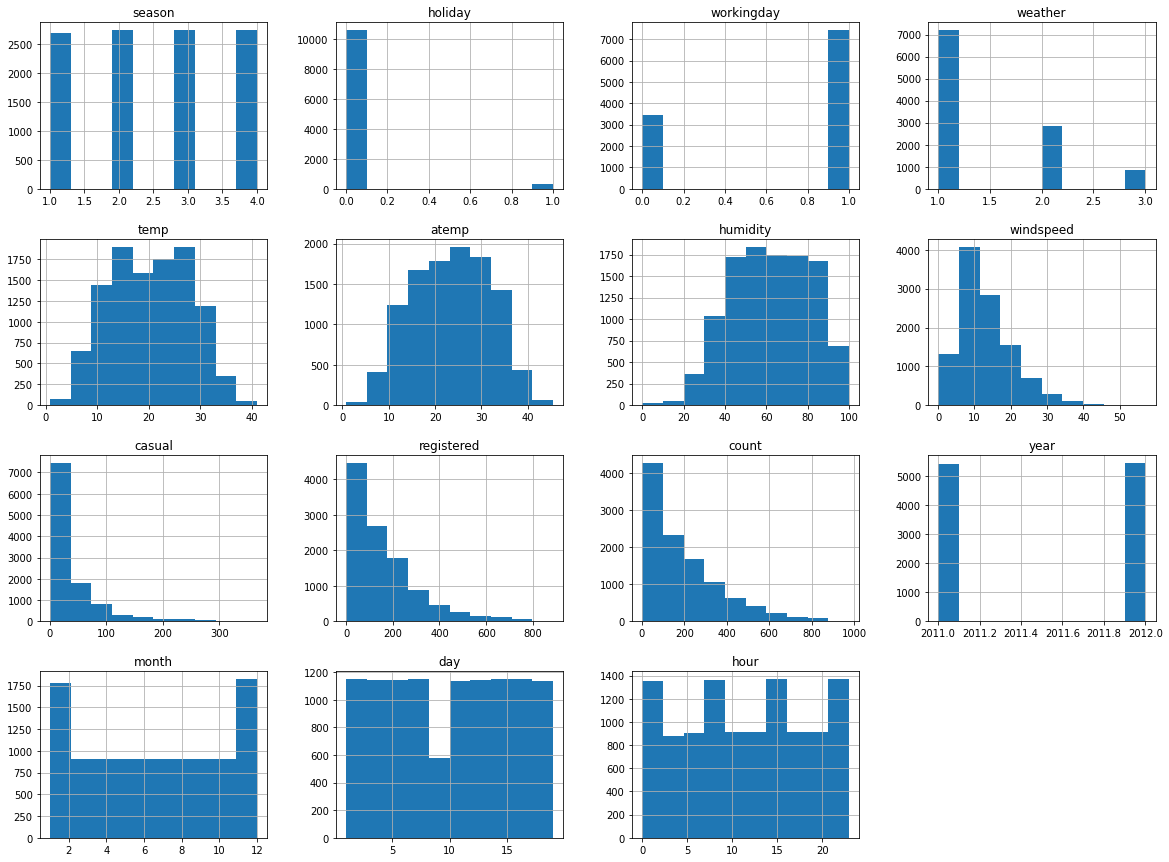

In [40]:
df.hist( figsize=(20,15))
plt.show()

### Heatmap to check correlations

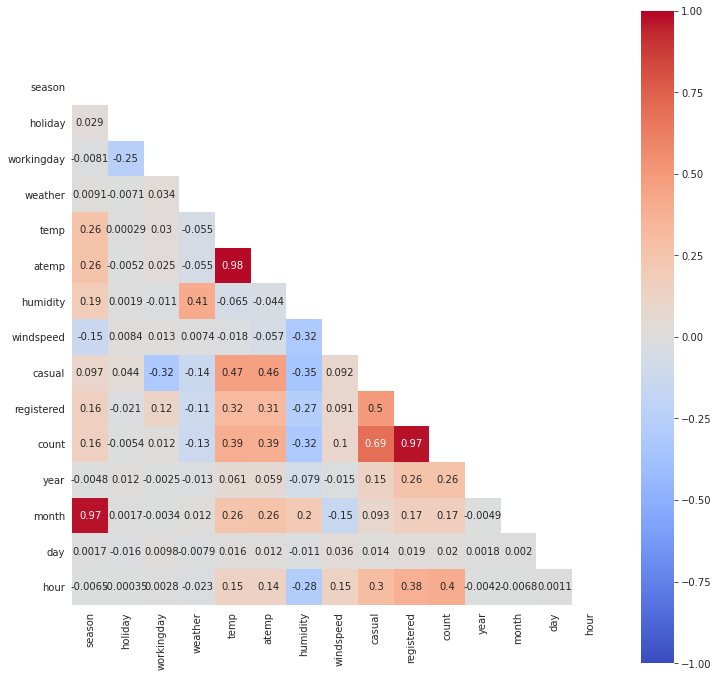

In [41]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)
plt.savefig('heatmap.jpg', dpi=200)

<b>Some observations

- Month and season has a high correlation

- Count, registered and casual have a high correlation, as count = registered+casual

- Temp and atemp has a high correlation

- We observe that time and temperature are most correlated with the count. On the other hand, we see that humidity and time negatively affect the count, followed by humidity and temperature.

In [42]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour'],
      dtype='object')

### Checking outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x7f72c31bfc70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f72c31bf580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f72c31bf070>],
 'medians': [<matplotlib.lines.Line2D at 0x7f72c8158730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f72c2f0a8e0>],
 'means': []}

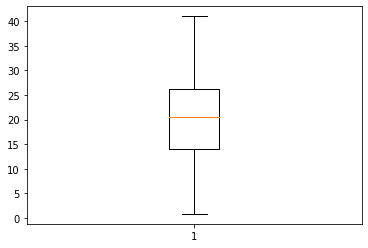

In [43]:
plt.boxplot(df.temp)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f72c306bbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f72c2ecf7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f72c306b940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f72c2ecf730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f72c2ed4520>],
 'means': []}

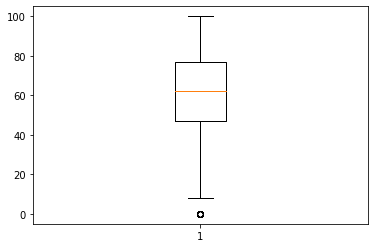

In [44]:
plt.boxplot(df.humidity)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f72c2df1790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f72c2df1a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f72c2df1310>],
 'medians': [<matplotlib.lines.Line2D at 0x7f72c2d68a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f72c2d68c70>],
 'means': []}

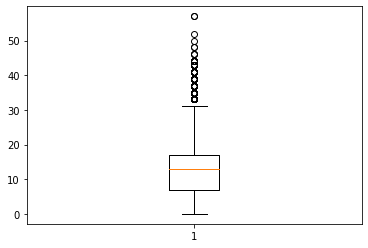

In [45]:
plt.boxplot(df.windspeed)

- After chechking the boxplots, I'm going to remove the outliers from windspeed and humidity

In [46]:
from scipy.stats import scoreatpercentile as pct
from scipy.stats import iqr
def remove_outliers(df):
    pct_75 = pct(df, 75)  # Calculate percentile 75 using scipy function scoreatpercentile
    pct_25 = pct(df, 25)  # Calculate percentile 25 using scipy function scoreatpercentile
    upper_bound = pct_75 + 1.5*iqr(df)  # iqr - > Scipy function to calculate the Interquartile Range
    lower_bound = pct_25 - 1.5*iqr(df)
    df = df[(df <= upper_bound) & (df >= lower_bound)]  # Filter out the outliers
    return df

In [47]:
len(df)

10886

In [48]:
df['windspeed'] = remove_outliers(df['windspeed'])

In [49]:
df = df.dropna()

In [50]:
len(df)

10659

In [51]:
df['humidity'] = remove_outliers(df['humidity'])

In [52]:
df = df.dropna()

In [53]:
len(df)

10638

- I have reduced my database in 2,3%

### Binning hour

- We have seen that hour is a very important feature, because depending on it the number of bikes changes a lot. That is why we want to incorporate it to our model. 
- Instead of adding 24 features (one for each hour), we group the hours in 5 different groups based on their demand for bikes: very low, low, medium, high or very high.
- We have to take into account that the demand is different on working days and non-working days.

- We create a new dataframe with a column called hour_bin to keep these values and assing them to a new column in our original dataframe

In [54]:
working_date["count"].mean(), weekends["count"].mean(), holiday_date["count"].mean()

(193.01187263896384, 188.7650964274423, 185.87781350482314)

In [55]:
working_date['hour_demand'] = working_date['hour'].replace([0,1,2,3,4,5],'very_low')
working_date['hour_demand'] = working_date['hour_demand'].replace([6,23,22],'low')
working_date['hour_demand'] = working_date['hour_demand'].replace([10,11,12,13,14,15,20,21],'medium')
working_date['hour_demand'] = working_date['hour_demand'].replace([7,9,16,19],'high')
working_date['hour_demand'] = working_date['hour_demand'].replace([8,17,18],'very_high')
weekends['hour_demand'] = weekends['hour'].replace([0,1,2,3,4,5,6,7,8,23],'very_low')
weekends['hour_demand'] = weekends['hour_demand'].replace([9,20,21,22],'low')
weekends['hour_demand'] = weekends['hour_demand'].replace([10,18,19],'medium')
weekends['hour_demand'] = weekends['hour_demand'].replace([11,12,13,14,15,16,17],'high')
holiday_date['hour_demand'] = holiday_date['hour'].replace([0,1,2,3,4,5,6,23],'very_low')
holiday_date['hour_demand'] = holiday_date['hour_demand'].replace([7,21,22],'low')
holiday_date['hour_demand'] = holiday_date['hour_demand'].replace([8,9,10,11,15,19,20],'medium')
holiday_date['hour_demand'] = holiday_date['hour_demand'].replace([12,13,14,16,17,18],'high')

<ipython-input-55-4176af062567>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['hour_demand'] = weekends['hour'].replace([0,1,2,3,4,5,6,7,8,23],'very_low')
<ipython-input-55-4176af062567>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['hour_demand'] = weekends['hour_demand'].replace([9,20,21,22],'low')
<ipython-input-55-4176af062567>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [56]:
working_date.shape, weekends.shape, holiday_date.shape

((7412, 17), (3163, 17), (311, 17))

In [57]:
df2 = pd.concat([weekends,holiday_date,working_date], axis=0)
df2.isna().sum()

datetime       0
season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
year           0
month          0
day            0
hour           0
hour_demand    0
dtype: int64

In [58]:
df["hour_demand"] = df2["hour_demand"]

In [59]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,hour_demand
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,2011,1,1,0,very_low
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,2011,1,1,1,very_low
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,2011,1,1,2,very_low
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,2011,1,1,3,very_low
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,2011,1,1,4,very_low


### Changing type to category to apply get dummies
- Some of our categorical variables has numerical type, we have to change it to categorical

In [60]:
df.dtypes

datetime       datetime64[ns]
season                  int64
holiday                 int64
workingday              int64
weather                 int64
temp                  float64
atemp                 float64
humidity              float64
windspeed             float64
casual                  int64
registered              int64
count                   int64
year                    int64
month                   int64
day                     int64
hour                    int64
hour_demand            object
dtype: object

- I change the weather numbers for the type of weather to make it nicer

In [61]:
df['weather'] = df['weather'].replace([1,2,3],['clear','cloudy','rain'])

- Also change humidity to float, as the other numerical variables

In [62]:
df['humidity'] = df['humidity'].astype(float)

In [63]:
df['season'] = pd.Categorical(df.season)
df['holiday'] = pd.Categorical(df.holiday)
df['workingday'] = pd.Categorical(df.workingday)
#df['weather'] = pd.Categorical(df.weather)
df['year'] = pd.Categorical(df.year)
df['month'] = pd.Categorical(df.month)
df['hour'] = pd.Categorical(df.hour)
df['hour_demand'] = pd.Categorical(df.hour_demand)

In [64]:
#sns.countplot(x="weather",hue="workingday",data=df).set(title='Response rate by the sales channel')

In [65]:
df = pd.get_dummies(data=df, columns=['month','hour','weather','hour_demand'], drop_first=True)

In [66]:
df.head()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,...,hour_20,hour_21,hour_22,hour_23,weather_cloudy,weather_rain,hour_demand_low,hour_demand_medium,hour_demand_very_high,hour_demand_very_low
0,2011-01-01 00:00:00,1,0,0,9.84,14.395,81.0,0.0,3,13,...,0,0,0,0,0,0,0,0,0,1
1,2011-01-01 01:00:00,1,0,0,9.02,13.635,80.0,0.0,8,32,...,0,0,0,0,0,0,0,0,0,1
2,2011-01-01 02:00:00,1,0,0,9.02,13.635,80.0,0.0,5,27,...,0,0,0,0,0,0,0,0,0,1
3,2011-01-01 03:00:00,1,0,0,9.84,14.395,75.0,0.0,3,10,...,0,0,0,0,0,0,0,0,0,1
4,2011-01-01 04:00:00,1,0,0,9.84,14.395,75.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,1


### X-y split. Which columns do I choose?

- X are all the features we want to use to predict y(the total number of bikes rented)

In [67]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'day',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weather_cloudy', 'weather_rain',
       'hour_demand_low', 'hour_demand_medium', 'hour_demand_very_high',
       'hour_demand_very_low'],
      dtype='object')

- Datetime: I don't need as I've split it into year, month, day and hour.
- Season: highly correlated with month, delete it.
- Holiday: it does not provide much information, what is relevant is to know if it is a workingday or not. Delete it
- Temp and atemp: highly correlated. I just keep temp
- Casual and registered: as are the sum of count (figure I am trying to predict, I don't need them.

In [68]:
X = df.drop(["datetime","season","atemp", "casual", "registered", "count", "day",'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'], axis=1)
y = df["count"]

In [69]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [70]:
X_train.head()

,holiday,workingday,temp,humidity,windspeed,year,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,weather_cloudy,weather_rain,hour_demand_low,hour_demand_medium,hour_demand_very_high,hour_demand_very_low
476,0,1,9.02,44.0,16.9979,2011,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8235,1,0,35.26,41.0,15.0013,2012,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1379,0,0,13.94,57.0,11.0014,2011,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3678,0,0,26.24,83.0,11.0014,2011,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6295,0,0,16.40,43.0,19.0012,2012,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'year',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weather_cloudy', 'weather_rain', 'hour_demand_low',
       'hour_demand_medium', 'hour_demand_very_high', 'hour_demand_very_low'],
      dtype='object')

In [72]:
#std_scaler=StandardScaler().fit(X_train)   ## finding the parameters (mean, variance from the training set )

#X_train_scaled=std_scaler.transform(X_train)
#X_test_scaled=std_scaler.transform(X_test)

### Feature Engineering

- We have already created dummie for the categorical features, but we also want to apply standard scaler to our numerical features

- Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

- We want to standardize only the columns we want. In the other columns we do not want to do anything. For this we use ColumnTransfomer, indicating what we want to do in each column. 

In [73]:
trans = ColumnTransformer([ #list of transformers with (name,method,columns)
    ('do_nothing', 'passthrough', ['workingday','holiday' ,'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year', 'weather_cloudy', 'weather_rain','hour_demand_very_low', 'hour_demand_low', 'hour_demand_medium',
       'hour_demand_very_high']),
    ('stand_scl', StandardScaler(), ['temp', 'humidity','windspeed'])
])    

- Apply the tranformation to X_train

In [74]:
trans.fit(X_train)

ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                 ['workingday', 'holiday', 'month_2', 'month_3',
                                  'month_4', 'month_5', 'month_6', 'month_7',
                                  'month_8', 'month_9', 'month_10', 'month_11',
                                  'month_12', 'year', 'weather_cloudy',
                                  'weather_rain', 'hour_demand_very_low',
                                  'hour_demand_low', 'hour_demand_medium',
                                  'hour_demand_very_high']),
                                ('stand_scl', StandardScaler(),
                                 ['temp', 'humidity', 'windspeed'])])

In [75]:
X_train_trans = trans.transform(X_train)   #we define X_trains_trans to train the model with the transformed data
X_test_trans = trans.transform(X_test)

### Apply linear regression

In [76]:
model=LinearRegression()    # model
model.fit(X_train_trans, y_train)   # model train

LinearRegression()

In [77]:
print("Coefficients:", model.coef_)
print("Intercept   :", model.intercept_)

Coefficients: [ -51.77579562  -21.86955087   13.24089256   29.45139762   56.38878455
   76.52331977   65.92178355   40.2202165    49.3793497    78.59646139
   98.86103592   78.50880729   75.80848756   85.46317503  -13.23195042
  -63.72692682 -272.81152782 -179.92091677 -117.29975191  204.67138272
   39.17431109  -17.01171645   -5.69098629]
Intercept   : -171608.2608269386


In [78]:
model.coef_

array([ -51.77579562,  -21.86955087,   13.24089256,   29.45139762,
         56.38878455,   76.52331977,   65.92178355,   40.2202165 ,
         49.3793497 ,   78.59646139,   98.86103592,   78.50880729,
         75.80848756,   85.46317503,  -13.23195042,  -63.72692682,
       -272.81152782, -179.92091677, -117.29975191,  204.67138272,
         39.17431109,  -17.01171645,   -5.69098629])

In [79]:
X_train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'year',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weather_cloudy', 'weather_rain', 'hour_demand_low',
       'hour_demand_medium', 'hour_demand_very_high', 'hour_demand_very_low'],
      dtype='object')

### Making predictions

In [80]:
y_pred=model.predict(X_test_trans)   # model prediction
y_pred_train=model.predict(X_train_trans)

In [81]:
y_test

10290      6
2994     141
9658     341
5579     512
10428    113
        ... 
3553     105
2466     285
9529     179
7558      75
9957     131
Name: count, Length: 3192, dtype: int64

<b> Comparting actual values(y_test) with our predictions

In [82]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
10290,6,34.276930
2994,141,252.952900
9658,341,326.802967
5579,512,358.064298
10428,113,159.238972
...,...,...
3553,105,110.931235
2466,285,339.573879
9529,179,297.903448
7558,75,280.908557


In [83]:
result.y_test.mean()

191.07205513784461

In [84]:
result.y_test.mean()

191.07205513784461

### Checking for errors

In [85]:
print ("MSE is " + str(round(mse(y_test,y_pred),2)))
print ("RMSE is " + str(round(mse(y_test,y_pred,squared=False),2)))
print ("Mean absolute error - MAE - is " + str(round(mae(y_test,y_pred),2)))

MSE is 5921.77
RMSE is 76.95
Mean absolute error - MAE - is 56.73


In [86]:
R2 = round(r2_score(y_test,y_pred),4)
R2

0.8141

-----------

### Analizing the model

What kind of plot you will get if all the all the predictions are ok? A stright line

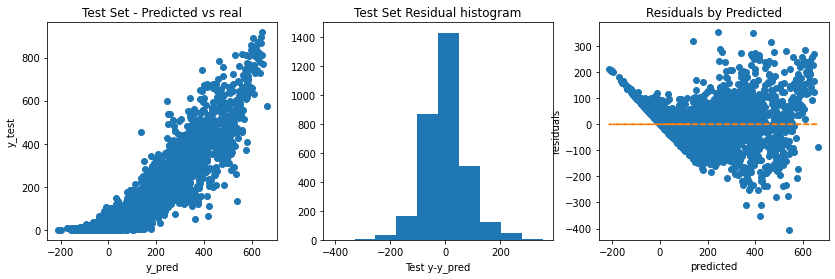

In [87]:
# Make an scatter plot y_pred vs y

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_pred")
ax[0].set_ylabel("y_test")
ax[0].set_title("Test Set - Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homosecdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.savefig('errors.jpg', dpi=200)

- First plot: there is linearity
- Second plot: we could see the residuals are normal distributed
- Third plot: residuals fairly constant in terms of Variance

### Evaluate error metrics also on test set

- If error_train very high -> Underfitting ( consider other model or to  add more variables)
- If error_train <= error_test -> Ok
- If error_train very small and <<<< error_test -> Overfitting!!!! ( you overtrained your model  or you did not applied the transformer to the test set ).

In [88]:
R2_test=model.score(X_test_trans,y_test)
R2_train=model.score(X_train_trans,y_train)

In [89]:
round(R2_test,4), round(R2_train,4) 

(0.8141, 0.8145)

### Feature importance
- In order to check which independent features are more relevant to your model, compare the absolute value of each coefficient.

In [90]:
X_train.shape

(7446, 23)

In [91]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [92]:
features_importances

,Attribute,Importance
16,month_12,272.811528
19,hour_demand_low,204.671383
17,weather_cloudy,179.920917
18,weather_rain,117.299752
10,month_6,98.861036
13,month_9,85.463175
9,month_5,78.596461
11,month_7,78.508807
5,year,76.523320
12,month_8,75.808488


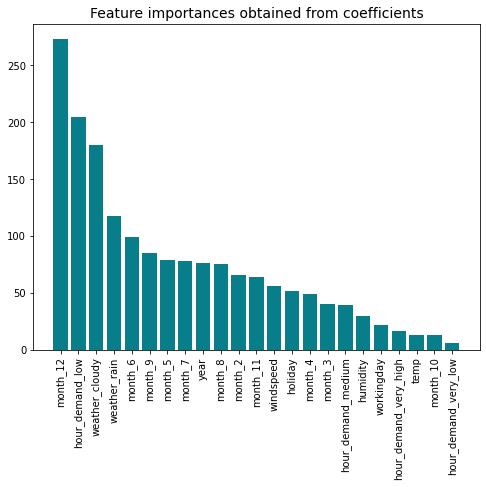

<Figure size 432x288 with 0 Axes>

In [93]:
plt.figure(figsize=(8, 6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=14)
plt.xticks(rotation='vertical')
plt.show()
plt.savefig('features.jpg', dpi=200)

In [94]:
X_train_trans = sm.add_constant(X_train_trans)
model = sm.OLS(y_train, X_train_trans).fit()
predictions_train = model.predict(X_train_trans)
X_test_trans = sm.add_constant(X_test_trans)
predictions_test = model.predict(X_test_trans)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1417.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:45:04   Log-Likelihood:                -43058.
No. Observations:                7446   AIC:                         8.616e+04
Df Residuals:                    7422   BIC:                         8.633e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.716e+05   3734.102    -45.957      0.0

### Conclusions

- High use for commuting to work

- Importance of year

- Reducing complexity (but without losing value)

- Categorical features > Nominal features

- Importance of temperature